<a href="https://colab.research.google.com/github/RicardoVilla0/MachineLearning/blob/main/Unidad%203/proyecto/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Importamos librerias necesarias para Random Forest Classifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

In [3]:
prestamos_df = pd.read_csv('prestamos_ok.csv')
prestamos_df.head()

,Unnamed: 0,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,issue_year,repaid,loan_term_year,purpose_code,home_ownership_code,grade_code,addr_state_code
0,0,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,...,Cash,N,NaN,2011,1,3,11,4,2,2
1,1,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,...,Cash,N,NaN,2011,1,3,9,4,2,0
2,2,3000,3000,3000.0,36 months,18.64,109.43,E,E1,MKC Accounting,...,Cash,N,NaN,2011,1,3,0,4,4,0
3,3,5600,5600,5600.0,60 months,21.28,152.39,F,F2,NaN,...,Cash,N,NaN,2011,0,5,11,3,5,0
4,4,5375,5375,5350.0,60 months,12.69,121.45,B,B5,Starbucks,...,Cash,N,NaN,2011,0,5,9,4,1,5


Usando 'loan_status' como variable objetivo
Top 20 variables por importancia:
recoveries                     0.183401
repaid                         0.182026
collection_recovery_fee        0.130836
total_rec_prncp                0.053298
last_credit_pull_d_Oct-2016    0.042331
total_pymnt                    0.029149
total_pymnt_inv                0.023912
last_pymnt_amnt                0.020859
loan_amnt                      0.010467
funded_amnt                    0.010203
funded_amnt_inv                0.009911
installment                    0.008695
total_rec_int                  0.008511
total_rec_late_fee             0.007481
int_rate                       0.006314
Unnamed: 0                     0.004754
annual_inc                     0.004718
grade_code                     0.004640
revol_util                     0.004423
revol_bal                      0.004203
dtype: float64


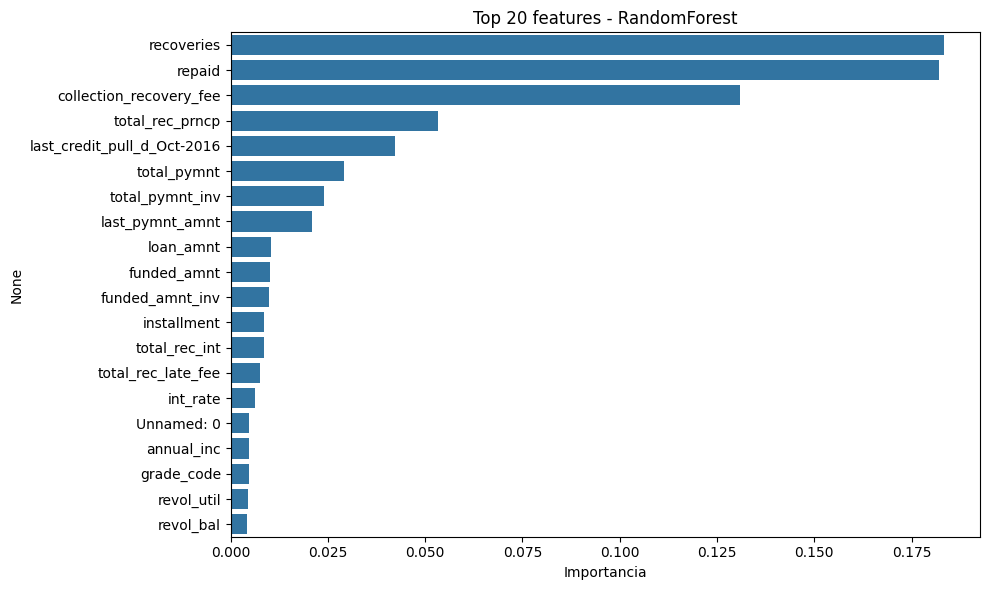

In [4]:
# detectar variable objetivo (ajusta la lista si tu target tiene otro nombre)
_possible_targets = ['target','default','defaulted','loan_status','loan_status_clean','status','y','label']
for _t in _possible_targets:
    if _t in prestamos_df.columns:
        y_col = _t
        break
else:
    y_col = prestamos_df.columns[-1]  # si no hay coincidencias, usa la última columna

print(f"Usando '{y_col}' como variable objetivo")

# preparar X, y
X = prestamos_df.drop(columns=[y_col])
y = prestamos_df[y_col]

# codificar y si no es numérico
if y.dtype == 'O' or str(y.dtype).startswith('category'):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y = le.fit_transform(y.astype(str))

# one-hot para categóricas y rellenar NA
X = pd.get_dummies(X, drop_first=True)
X = X.fillna(0)

# dividir (si hay >1 clase, estratificar)
strat = y if len(np.unique(y)) > 1 else None
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=strat)

# entrenar RandomForest y obtener importancias
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# mostrar top 20
print("Top 20 variables por importancia:")
print(importances.head(20))

# gráfico rápido
plt.figure(figsize=(10,6))
sns.barplot(x=importances.head(20).values, y=importances.head(20).index)
plt.title('Top 20 features - RandomForest')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()


In [5]:
X = prestamos_df[['recoveries', 'collection_recovery_fee', 'total_rec_prncp',
                  'total_pymnt', 'total_pymnt_inv',
                  'last_pymnt_amnt', 'loan_amnt']]

# Variable objetivo o variable a predecir
y = prestamos_df["repaid"]

In [6]:
# Dividimos el dataFrame
# stratify es para que mantenga la misma proporción de clases en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size= 0.3, stratify=y )

In [7]:
# verificamos la cantidad de registros asignados al dataframe de entrenamiento
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13935, 7), (5973, 7), (13935,), (5973,))

In [8]:
# --- Normalización de variables ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# --- Definimos el modelo SVM ---
svm_model = SVC(
    kernel='rbf',          # radial basis function (no lineal)
    C=1.0,                 # penalización por errores
    gamma='scale',         # ajuste automático de gamma
    class_weight='balanced',  # útil si hay desbalance
    probability=True,      # permite obtener probabilidades
    random_state=42
)

# --- Entrenamiento ---
svm_model.fit(X_train_scaled, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [10]:
# --- Predicción ---
y_pred_svm = svm_model.predict(X_test_scaled)

print("Reporte de Clasificación (SVM):")
print(classification_report(y_test, y_pred_svm, target_names=["No Pagado", "Pagado"]))

print("Matriz de Confusión (SVM):")
print(confusion_matrix(y_test, y_pred_svm))

Reporte de Clasificación (SVM):
              precision    recall  f1-score   support

   No Pagado       0.92      0.95      0.93       883
      Pagado       0.99      0.99      0.99      5090

    accuracy                           0.98      5973
   macro avg       0.96      0.97      0.96      5973
weighted avg       0.98      0.98      0.98      5973

Matriz de Confusión (SVM):
[[ 835   48]
 [  70 5020]]


In [11]:
##  Probabilidades de la clase positiva ##

from sklearn.metrics import roc_curve, roc_auc_score
import plotly.graph_objects as go

# --- Probabilidades de la clase positiva ("Pagado" = 1) ---
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

# --- Calcular AUC-ROC ---
auc = roc_auc_score(y_test, y_prob_svm)
print(f"\n AUC-ROC: {auc:.3f}")

# --- Curva ROC ---
fpr, tpr, thresholds = roc_curve(y_test, y_prob_svm)

# --- Gráfica interactiva con Plotly ---
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='SVM', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Aleatorio', line=dict(dash='dash')))
fig.update_layout(
    title=f'Probabilidades de la clase positiva - Curva ROC (AUC = {auc:.3f})',
    xaxis_title='Tasa de Falsos Positivos (1 - Especificidad)',
    yaxis_title='Tasa de Verdaderos Positivos (Sensibilidad)',
    width=700, height=500
)
fig.show()



 AUC-ROC: 0.998


In [12]:
# --- Probabilidades de la clase negativa ("Pagado" = 0) ---
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 0]

# --- Calcular AUC-ROC ---
auc = roc_auc_score(y_test, y_prob_svm)
print(f"\nAUC-ROC: {auc:.3f}")

# --- Curva ROC ---
fpr, tpr, thresholds = roc_curve(y_test, y_prob_svm)

# --- Gráfica interactiva con Plotly ---
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='SVM', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Aleatorio', line=dict(dash='dash')))
fig.update_layout(
    title=f'Probabilidades de la clase negativa - Curva ROC (AUC = {auc:.3f})',
    xaxis_title='Tasa de Falsos Positivos (1 - Especificidad)',
    yaxis_title='Tasa de Verdaderos Positivos (Sensibilidad)',
    width=700, height=500
)
fig.show()


AUC-ROC: 0.002


In [13]:
# ===============================================
# 📈 Curvas ROC para ambas clases (positiva y negativa)
# ===============================================

from sklearn.metrics import roc_curve, roc_auc_score
import plotly.graph_objects as go

# --- Probabilidades predichas por el modelo ---
# Asegúrate de tener esto antes:
# svm_model.fit(X_train_scaled, y_train)
# y_prob_svm = svm_model.predict_proba(X_test_scaled)

# Calcular probabilidades y AUC para ambas clases
y_prob = svm_model.predict_proba(X_test_scaled)

# Clase positiva (Pagado = 1)
fpr_pos, tpr_pos, _ = roc_curve(y_test, y_prob[:, 1], pos_label=1)
auc_pos = roc_auc_score(y_test, y_prob[:, 1])

# Clase negativa (No Pagado = 0)
fpr_neg, tpr_neg, _ = roc_curve(y_test, y_prob[:, 0], pos_label=0)
auc_neg = roc_auc_score(y_test, y_prob[:, 0])

# --- Graficar con Plotly ---
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=fpr_pos, y=tpr_pos,
    mode='lines',
    name=f'Clase positiva (Pagado) - AUC = {auc_pos:.3f}',
    line=dict(color='blue', width=2)
))

fig.add_trace(go.Scatter(
    x=fpr_neg, y=tpr_neg,
    mode='lines',
    name=f'Clase negativa (No Pagado) - AUC = {auc_neg:.3f}',
    line=dict(color='green', width=2)
))

# Línea diagonal (modelo aleatorio)
fig.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    name='Aleatorio',
    line=dict(color='red', width=1, dash='dash')
))

# --- Personalización del gráfico ---
fig.update_layout(
    title="Comparación de Curvas ROC - Clases Positiva y Negativa",
    xaxis_title="Tasa de Falsos Positivos (1 - Especificidad)",
    yaxis_title="Tasa de Verdaderos Positivos (Sensibilidad)",
    width=900, height=600,
    legend=dict(x=0.6, y=0.05)
)

fig.show()


In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score, classification_report, confusion_matrix
import numpy as np

# Definimos el F2-score como métrica personalizada (recall más importante que precisión)
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=0)

# Modelo base
svm = SVC(probability=False, class_weight='balanced', random_state=42)

# Definimos los hiperparámetros a explorar
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3],  # solo afecta al kernel 'poly'
}

# Configuración del GridSearchCV
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring=f2_scorer,  # optimizamos el F2-score
    cv=5,               # validación cruzada de 5 particiones
    verbose=2,
    n_jobs=-1           # usa todos los núcleos disponibles
)

# Entrenamiento
print("Entrenando GridSearchCV para SVM...\n")
grid_search.fit(X_train_scaled, y_train)

# Resultados
print("\n Búsqueda finalizada.")
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

print("\nMejor puntaje promedio (F2-score):")
print(round(grid_search.best_score_, 4))

# Evaluación con los mejores parámetros
svm_optimo = grid_search.best_estimator_
y_pred_opt = svm_optimo.predict(X_test_scaled)

print("\n Reporte de Clasificación (SVM optimizado para impagos):\n")
print(classification_report(y_test, y_pred_opt, target_names=["No Pagado", "Pagado"]))

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_opt))


Entrenando GridSearchCV para SVM...

Fitting 5 folds for each of 36 candidates, totalling 180 fits

 Búsqueda finalizada.
Mejores hiperparámetros encontrados:
{'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

Mejor puntaje promedio (F2-score):
0.9659

 Reporte de Clasificación (SVM optimizado para impagos):

              precision    recall  f1-score   support

   No Pagado       0.95      0.97      0.96       883
      Pagado       1.00      0.99      0.99      5090

    accuracy                           0.99      5973
   macro avg       0.97      0.98      0.98      5973
weighted avg       0.99      0.99      0.99      5973

Matriz de Confusión:
[[ 859   24]
 [  42 5048]]
